# MetaTiME for Cell State Annotator and Cell Signature Mapper

### installation for colab

In [4]:
##Calling matplotlib first help avoid error in colab when plotting
import matplotlib
import matplotlib.pyplot as plt
!wget -q https://www.dropbox.com/s/gnmgfxa85basvwq/logo.png
img = matplotlib.image.imread('./logo.png', 0)

logo = plt.imshow( img ) # for test the colab matplotlib. a logo shall be plotted:)
_=plt.axis('off')

## install
!pip install scanpy 
!pip install metatime
!pip install anndata
!pip install adjustText
!pip install leidenalg
!pip install harmonypy


## imports

In [5]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import scanpy as sc


import importlib as imp
import metatime
import matplotlib
import matplotlib.pyplot as plt
"""
## For local testing in dev
METATIME_DIR = '../../metatime/'
if METATIME_DIR not in sys.path:
    sys.path.append(METATIME_DIR)
file = '../notebooks_dev/BCC_GSE123813_aPD1_with_metainfo.h5ad'
## 
"""

from metatime import config
from metatime import loaddata
from metatime import mecmapper
from metatime import mecs
from metatime import annotator
from metatime import plmapper
from metatime import dmec
import matplotlib

## Get sample data

In [ ]:

#!wget -O testdata.h5ad https://www.dropbox.com/s/0sj6gtppsfr2ouo/NSCLC_GSE117570_res.pp.h5ad?dl=0

!wget -O testdata.h5ad https://www.dropbox.com/s/f791mv3tnhs9fii/BCC_GSE123813_aPD1_with_metainfo.h5ad

## Load scRNA data

In [ ]:
file = 'testdata.h5ad' 

### Or provide path to local file

In [3]:
# file = '../notebooks_dev/BCC_GSE123813_aPD1_with_metainfo.h5ad' # Yost et al. 2019 Nat Med.

### Load data

In [7]:
adata = loaddata.load(file = file)

 Loaded ../notebooks_dev/BCC_GSE123813_aPD1_with_metainfo.h5ad


## Processing and Harmonize

If your data contains count matrix, we provide a wrapped function for pre-processing the data.

Otherwise, if the data is already depth-normalized, log-transformed, and cells are filtered, we can skip this step.

In [21]:
# adata = loaddata.adatapp( adata )

The sample data has multiple patients , and we can use batch correction on patients.


In [8]:
batchcols = ['patient']
adata = loaddata.batchharmonize( adata, batchcols = batchcols, random_state = 0 )  

[Log ] hamonize with batch  ['patient']


2023-03-08 10:35:47,244 - harmonypy - INFO - Iteration 1 of 10
2023-03-08 10:36:10,542 - harmonypy - INFO - Iteration 2 of 10
2023-03-08 10:36:31,396 - harmonypy - INFO - Iteration 3 of 10
2023-03-08 10:36:52,290 - harmonypy - INFO - Iteration 4 of 10
2023-03-08 10:37:15,135 - harmonypy - INFO - Iteration 5 of 10
2023-03-08 10:37:35,731 - harmonypy - INFO - Iteration 6 of 10
2023-03-08 10:37:50,593 - harmonypy - INFO - Iteration 7 of 10
2023-03-08 10:38:04,054 - harmonypy - INFO - Iteration 8 of 10
2023-03-08 10:38:29,634 - harmonypy - INFO - Iteration 9 of 10
2023-03-08 10:38:50,853 - harmonypy - INFO - Iteration 10 of 10
2023-03-08 10:39:10,944 - harmonypy - INFO - Stopped before convergence


[Log ] Recomputing umap 


It is recommended that malignant cells are identified first and removed for best practice in cell state annotation.

In the BCC data, the cluster of malignant cells are identified with inferCNV. We can use the pre-saved column 'isTME' to keep Tumor Microenvironment cells

In [9]:
adata = adata[adata.obs['isTME']]

We can over-cluster the cells which is useful for fine-grained cell state annotation.

In [10]:
adata = annotator.overcluster( adata ) # this generates a 'overcluster' columns in adata.obs

/homes6/yiz/Tools/pip/pippy3/lib/python3.7/site-packages/scanpy/tools/_leiden.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  categories=natsorted(map(str, np.unique(groups))),


## Load MetaTiME trained model for TME

Next, let's load the pre-computed MetaTiME MetaComponents (MeCs), and their functional annotation.

In [11]:
# Load the pre-trained MeCs
mecmodel = mecs.MetatimeMecs.load_mec_precomputed()

# Load functional annotation for MetaTiME-TME
mectable = mecs.load_mecname( mecDIR = config.SCMECDIR, mode ='table' )
mecnamedict = mecs.getmecnamedict_ct(mectable) 


## Project on MeC space

We can project each cell onto this functional MeC space.

In [12]:
pdata = mecmapper.projectMecAnn(adata, mecmodel.mec_score)

/liulab/yiz/proj/MetaTiME/metatime/mecmapper.py:151: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adataproj = anndata.AnnData( projected, obs = adata.obs )


### Per-cell score projected on MeC space

Convert to table to look at per-cell projection scores

In [14]:
projmat, mecscores = annotator.pdataToTable(pdata, mectable, gcol = 'overcluster')
mecscores

0: Pan_Interferon-response  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG                    -0.819890   
bcc.su001.pre.tcell_AAACGGGCATAGACTC                     0.497730   
bcc.su001.pre.tcell_AAACGGGTCATACGGT                    -0.853597   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT                     1.643644   
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT                    -0.904096   
...                                                           ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT                   -0.655006   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA                   -1.002944   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC                   -0.705487   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC                    0.205688   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT                   -0.059757   

                                       1: Pan_Proliferation-S  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG                -0.688164   
bcc.su001.pre.tcell_AAACGGGCATAGACTC                -0.781702   
bcc.su001.pre.tcell_AAACGGGTCATACGGT                 0.389129   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT                -0.217423   
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT                -0.855004   
...                                                       ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT               -0.323290   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA               -0.177266   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC               -0.384236   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC               -0.372909   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT                0.314007   

                                       2: Pan_Heat-stress  3: DC_pDC  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG            -1.293394  -0.623175   
bcc.su001.pre.tcell_AAACGGGCATAGACTC            -1.236870  -0.225077   
bcc.su001.pre.tcell_AAACGGGTCATACGGT             2.834898  -0.235956   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT            -0.643116   0.088754   
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT            -1.025405  -0.417323   
...                                                   ...        ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT            1.357172  -0.252120   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA            1.441417  -0.175024   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC            1.495082  -0.411420   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC            1.382011   0.256174   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT            1.000176  -0.132242   

                                       4: B_Plasma  5: Pan_Proliferation-G2-M  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG     -0.619621                  -0.014213   
bcc.su001.pre.tcell_AAACGGGCATAGACTC     -0.407063                  -0.196667   
bcc.su001.pre.tcell_AAACGGGTCATACGGT      0.469343                   0.946867   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT     -0.523546                  -1.255705   
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT     -0.265433                  -0.517993   
...                                            ...                        ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT    -0.477362                  -0.562883   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA    -0.643992                  -1.178595   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC    -0.401349                  -0.957136   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC    -0.391342                   0.236742   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT     0.371538                  -0.351378   

                                       6: DC_cDC2-MHCII  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG          -0.421470   
bcc.su001.pre.tcell_AAACGGGCATAGACTC          -0.708806   
bcc.su001.pre.tcell_AAACGGGTCATACGGT          -0.673814   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT          -0.849190   
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT          -0.371883   
...                                                 ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT         -0.469015   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA         -1.009185   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC         -1.487738   
b

## Cell state annotator and save the results to scRNA objects

Based on per-cell projection scores, compute the per-cluster cell state scores, and find out the top 1st enriched cell state.

Save the cluster-wise cell state annotation.

Or, it can also be saved to the scanpy object "pdata", containing only the scores, which is smaller to save.

In [15]:
projmat, gpred, gpreddict = annotator.annotator( projmat,  mecnamedict, gcol = 'overcluster')

adata = annotator.saveToAdata( adata, projmat )
pdata = annotator.saveToPdata( pdata, adata, projmat )


/liulab/yiz/proj/MetaTiME/metatime/annotator.py:190: UserWarning: Columns in projmat already overlap columns in adata.obs. Overwriting adata.obs. 
  warnings.warn('Columns in projmat already overlap columns in adata.obs. Overwriting adata.obs. '


New columns added to adata and pdata:
   - MetaTiME_overcluster

In [16]:
## Simplify the cell states as on UMAP plot by updating:
##  adata, pdata, mecnamedict
adata.obs['MetaTiME'] = adata.obs['MetaTiME_overcluster'].str.split(': ').str.get(1)
pdata.obs['MetaTiME'] = pdata.obs['MetaTiME_overcluster'].str.split(': ').str.get(1)
mecnamedict_simp = mecnamedict.copy()
_=[mecnamedict_simp.update({t: mecnamedict[t].split(': ')[1]}) for t in mecnamedict.keys()]

New columns added to adata and pdata:
   - MetaTiME
   
A simplified naming dictory:
   - mecnamedict_simp

### Plot per-cluster, Top1 enriched cell states 

/homes6/yiz/Tools/pip/pippy3/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


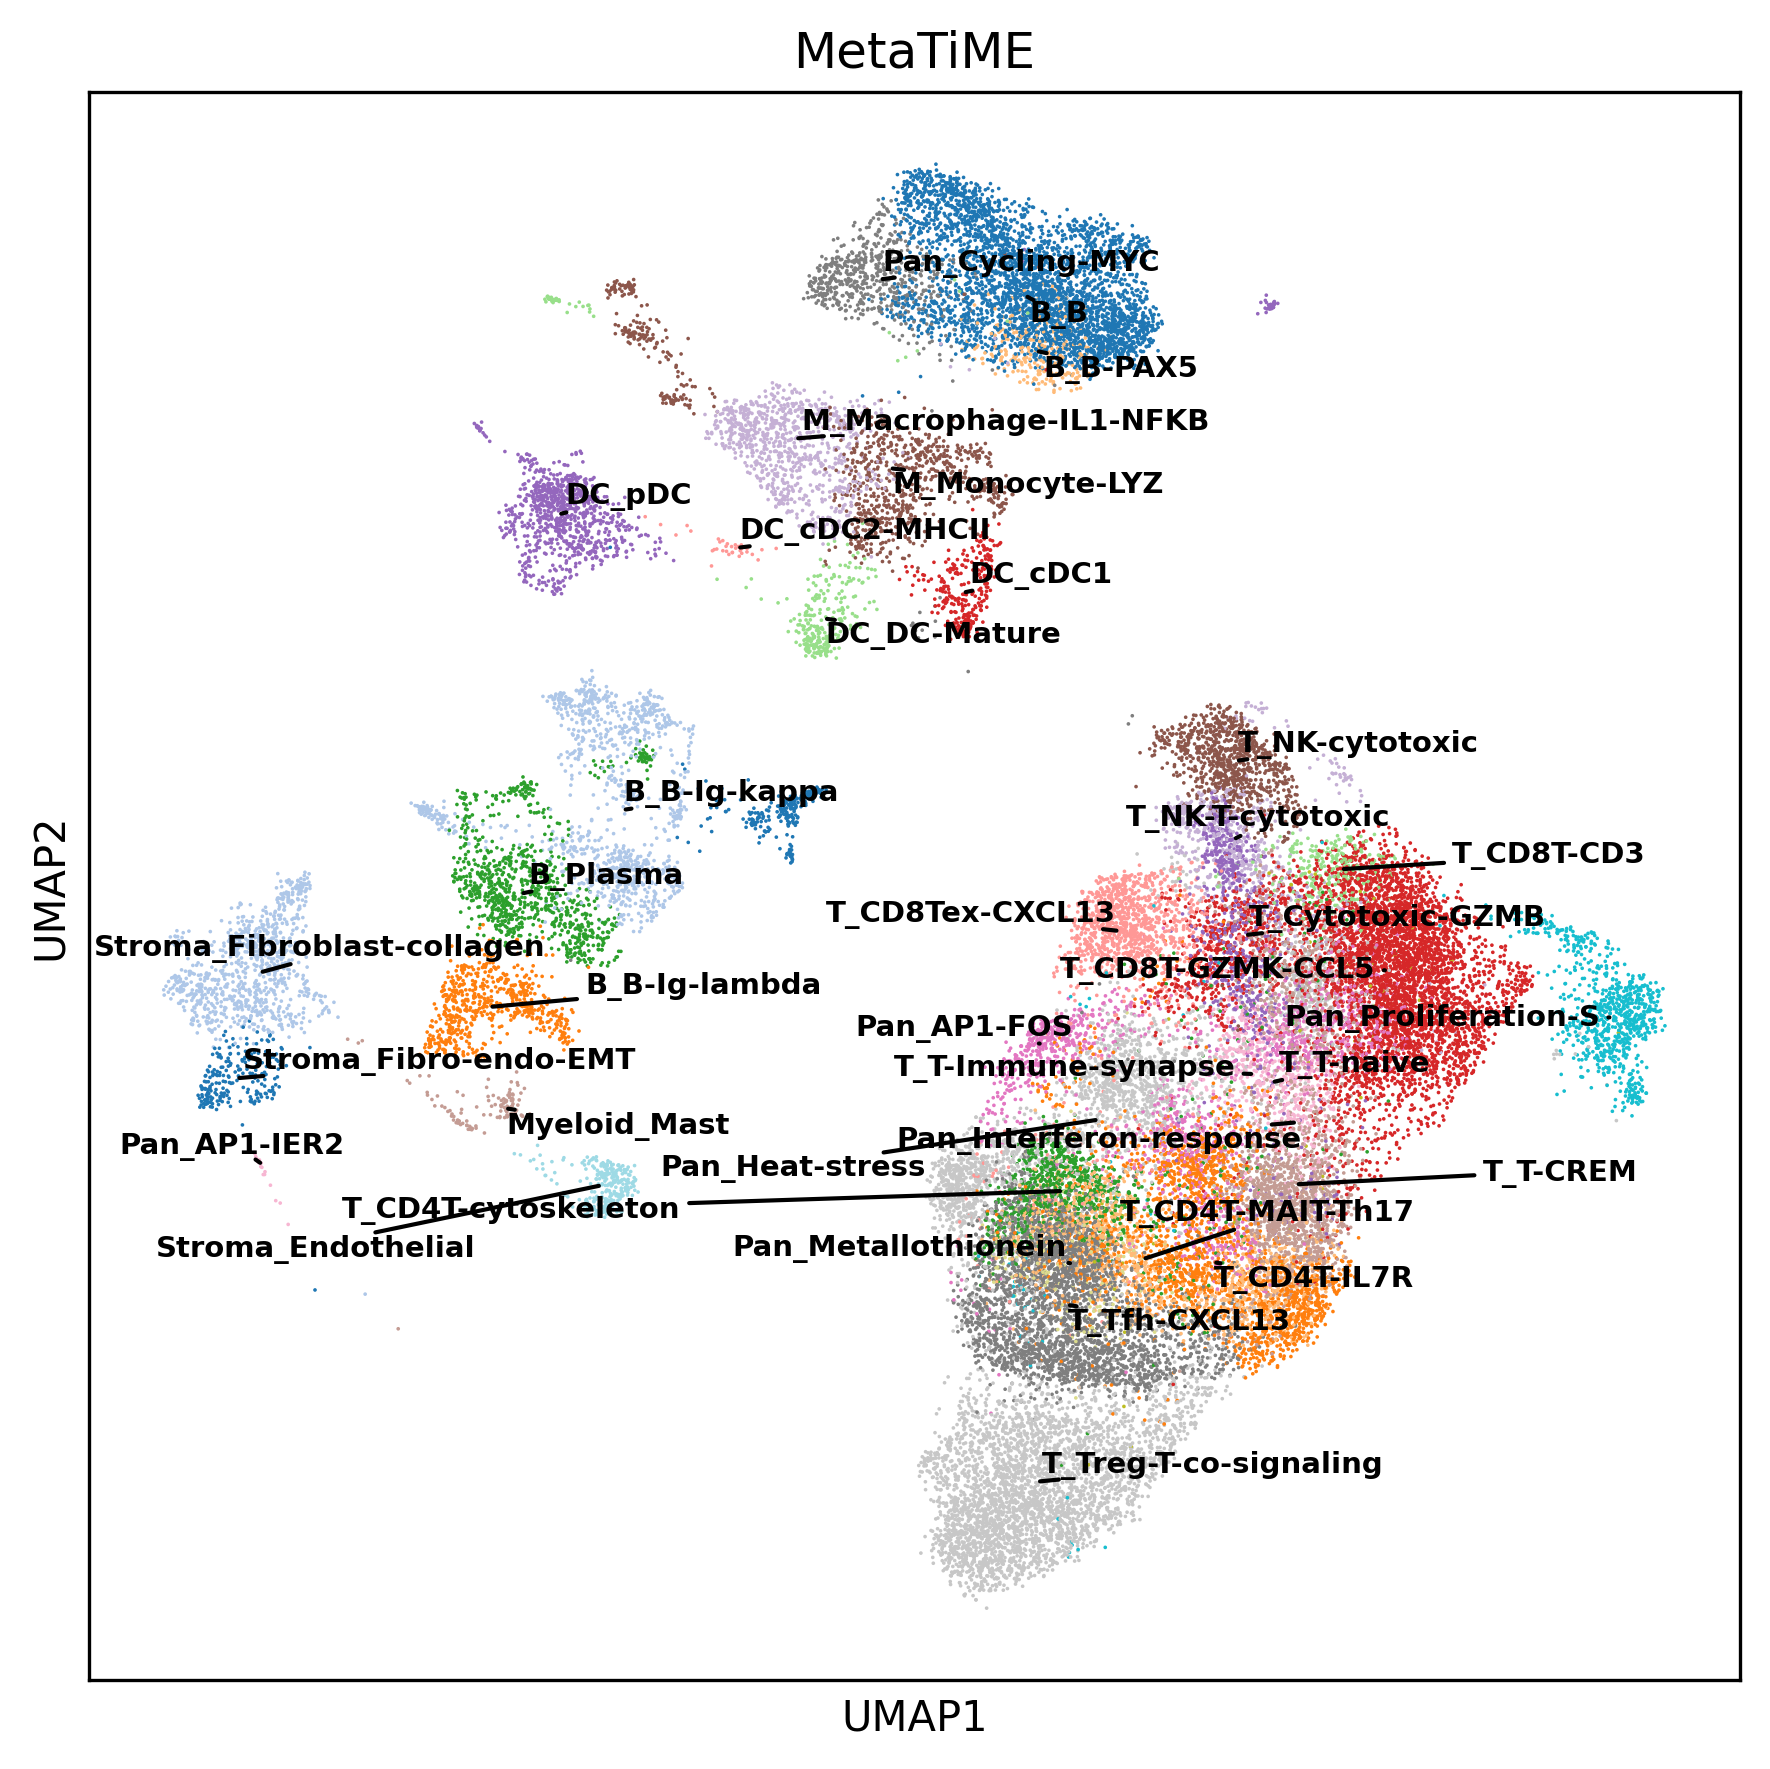

In [17]:
fig,ax = plmapper.plot_annotation_on_data( adata, COL = 'MetaTiME', fontsize=7 )

### Check the list of MeCs

In [18]:
mecnamedict_simp

{'MeC_0': 'Pan_Interferon-response',
 'MeC_1': 'Pan_Proliferation-S',
 'MeC_2': 'Pan_Heat-stress',
 'MeC_3': 'DC_pDC',
 'MeC_4': 'B_Plasma',
 'MeC_5': 'Pan_Proliferation-G2-M',
 'MeC_6': 'DC_cDC2-MHCII',
 'MeC_7': 'T_Treg-T-co-signaling',
 'MeC_8': 'T_NK-cytotoxic',
 'MeC_9': 'M_Monocyte-CD16',
 'MeC_11': 'T_NK-T-cytotoxic',
 'MeC_12': 'T_CD8T-GZMK-CCL5',
 'MeC_13': 'Myeloid_Mast',
 'MeC_14': 'Pan_Proliferation',
 'MeC_15': 'Pan_Ribosome',
 'MeC_16': 'T_CD4T-MAIT-Th17',
 'MeC_17': 'M_Monocyte-CD14',
 'MeC_18': 'B_B',
 'MeC_19': 'M_Macrophage-C1Q',
 'MeC_20': 'T_Tfh-CXCL13',
 'MeC_21': 'T_CD4T-cytoskeleton',
 'MeC_22': 'Stroma_Fibroblast-collagen',
 'MeC_23': 'Stroma_Endothelial',
 'MeC_24': 'Pan_Metallothionein',
 'MeC_25': 'T_Cytotoxic-GZMB',
 'MeC_26': 'M_Macrophage-SPP1',
 'MeC_27': 'Stroma_Fibro-endo-EMT',
 'MeC_28': 'Pan_Beta-catenin',
 'MeC_29': 'M_Monocyte-CD14-S100A12',
 'MeC_30': 'B_B-Ig-kappa',
 'MeC_31': 'Pan_Protein-processing',
 'MeC_32': 'T_CD8T-CD3',
 'MeC_33': 'Pan_Cycl

### Plot signature continuum for a single MeC

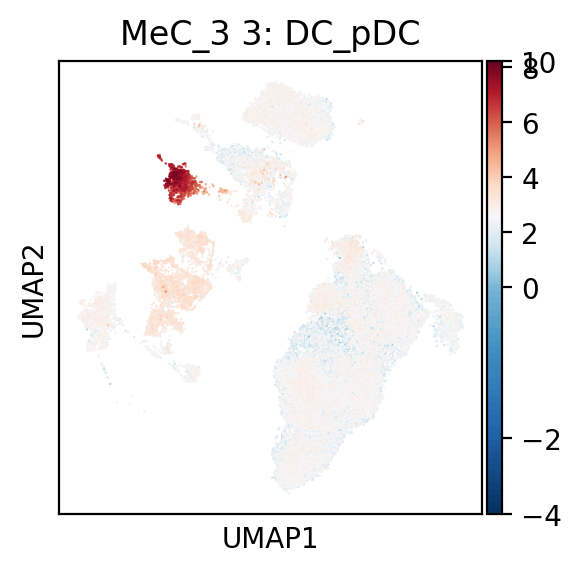

In [19]:
fig=plmapper.plot_umap_mec( pdata, 'MeC_3' ,mecnamedict, figfile =None)

### Plot signature continuum for all functional MeCs

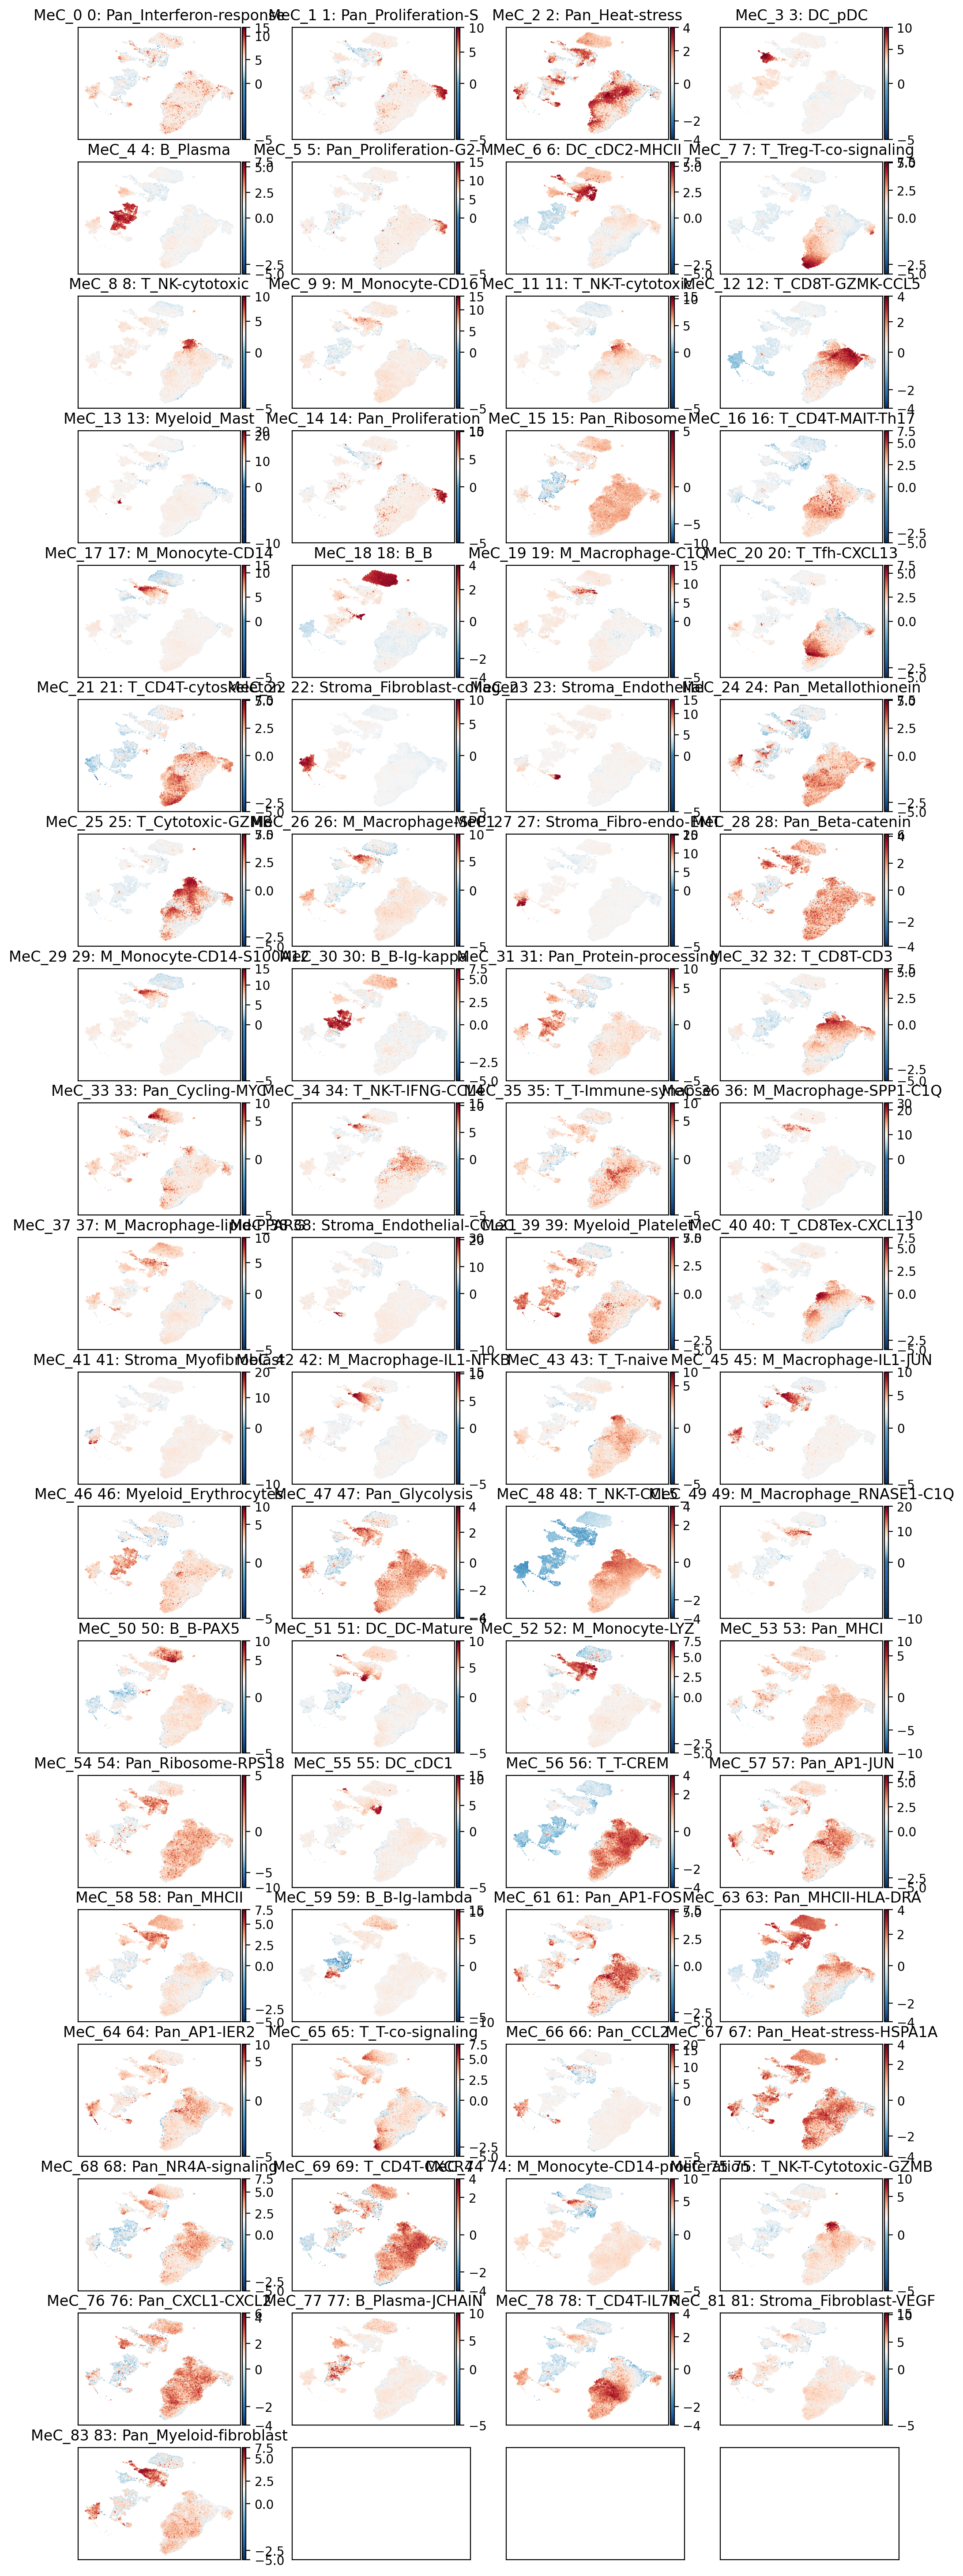

In [20]:
fig=plmapper.plot_umap_proj_pdata( pdata, mecnamedict , figfile =None)

# Comparing conditions

## Counting cells

The first way is to count cells newly annotated by MetaTiME. A count table can be returned in all ways grouping the cells. The conditions here are dataset - specific.

In [21]:
condcol = 'treatment' 
clustercol = 'MetaTiME' 
samplecol = 'patient'

cellcts = dmec.count_cell_condition( adata.obs, countbycols = [condcol, clustercol, samplecol] )
#cellcts.to_csv('./cell_counts.txt',sep='\t')
cellcts

patient                           su001  su002  su003  su004  su005  su006  \
treatment MetaTiME                                                           
post      B_B                    3447.0    0.0    8.0   19.0   55.0   18.0   
          B_B-Ig-kappa             12.0    3.0    0.0    3.0    8.0  537.0   
          B_B-Ig-lambda             7.0    1.0    1.0    2.0    3.0   76.0   
          B_B-PAX5                273.0    0.0    0.0    0.0    0.0    0.0   
          B_Plasma                 15.0    4.0    0.0    5.0   16.0  164.0   
...                                 ...    ...    ...    ...    ...    ...   
pre       T_T-CREM                 72.0    4.0    7.0   33.0   64.0   83.0   
          T_T-Immune-synapse       47.0    0.0    6.0   22.0   28.0   35.0   
          T_T-naive                 1.0    0.0    2.0   13.0   13.0    2.0   
          T_Tfh-CXCL13             25.0    2.0    9.0   16.0   74.0  335.0   
          T_Treg-T-co-signaling   200.0    6.0    8.0   52.0   79.0  300.0   

patient                          su007  su008  su009  su010  su012  
treatment MetaTiME                                                  
post      B_B                      2.0  127.0    2.0    0.0    0.0  
          B_B-Ig-kappa             0.0   27.0    0.0    0.0    2.0  
          B_B-Ig-lambda            2.0   32.0    0.0    0.0    0.0  
          B_B-PAX5                 0.0    0.0    0.0    0.0    0.0  
          B_Plasma                 2.0   23.0    8.0    0.0    2.0  
...                                ...    ...    ...    ...    ...  
pre       T_T-CREM               126.0   12.0  324.0    7.0  100.0  
          T_T-Immune-synapse      82.0    4.0  146.0    6.0  130.0  
          T_T-naive               22.0    1.0  113.0    0.0   13.0  
          T_Tfh-CXCL13            94.0   87.0  408.0    0.0  465.0  
          T_Treg-T-co-signaling  166.0   90.0  338.0    3.0  353.0  

[76 rows x 11 columns]

Writing the cell counts to table

In [22]:
cellcts.to_csv('./cell_counts.txt',sep='\t')

## Differential signature

MetaTiME also provides functions to test differential signatures cluster-wise.

In [25]:
condcol = 'treatment' # the column in adata.obs to mark the condition
cond1 = ['pre'] # Condition 1 in adata.obs[ condcol ], 
cond2 = ['post'] # Condition 2 in adata.obs[ condcol ], 
clustercol = 'MetaTiME' # MetaTiME annotated cluster labels 


# get the cell barcodes for two conditions
allcellscond1= adata[adata.obs[ condcol ].isin(cond1), ].obs.index
allcellscond2= adata[adata.obs[ condcol ].isin(cond2), ].obs.index

In [26]:
print(f'Compare cells based on {condcol} with conditions {cond1} and {cond2}')
print(f'Cells in Condition {cond1} : {len(allcellscond1)}')
print(f'Cells in Condition {cond2} : {len(allcellscond2)}')

Compare cells based on treatment with conditions ['pre'] and ['post']
Cells in Condition ['pre'] : 13710
Cells in Condition ['post'] : 25126


Get A table listing all signatures enriching in each cluster, as candidate for testing differential signature.

In [27]:
mec_enriched = dmec.enrich_mec( 
    adata=pdata, labelcol =clustercol, mecnamedict=mecnamedict_simp)


Testing all candidate signatures in each cell cluster.

In [29]:

diffmec, diffmecsig, diffmec_full = dmec.dmec(adata, pdata, allcellscond1, allcellscond2, clustercol, mec_enriched, mecnamedict_simp,
                                              test_clusters='all', test_method = 'ttest' )


Plotting the differential signature dot plot.


X-axis: difference of mean signature scores between conditions. Y-axis: -⁡log(p-value) from the test statistic chosen. The significant cluster-wise differential signature is marked as “EnrichedMeC@ClusterName”; when the enriched MeC is the same as cluster name, the signature is marked “ClusterName”. Size of the dots is proportionally to the mean signature score.

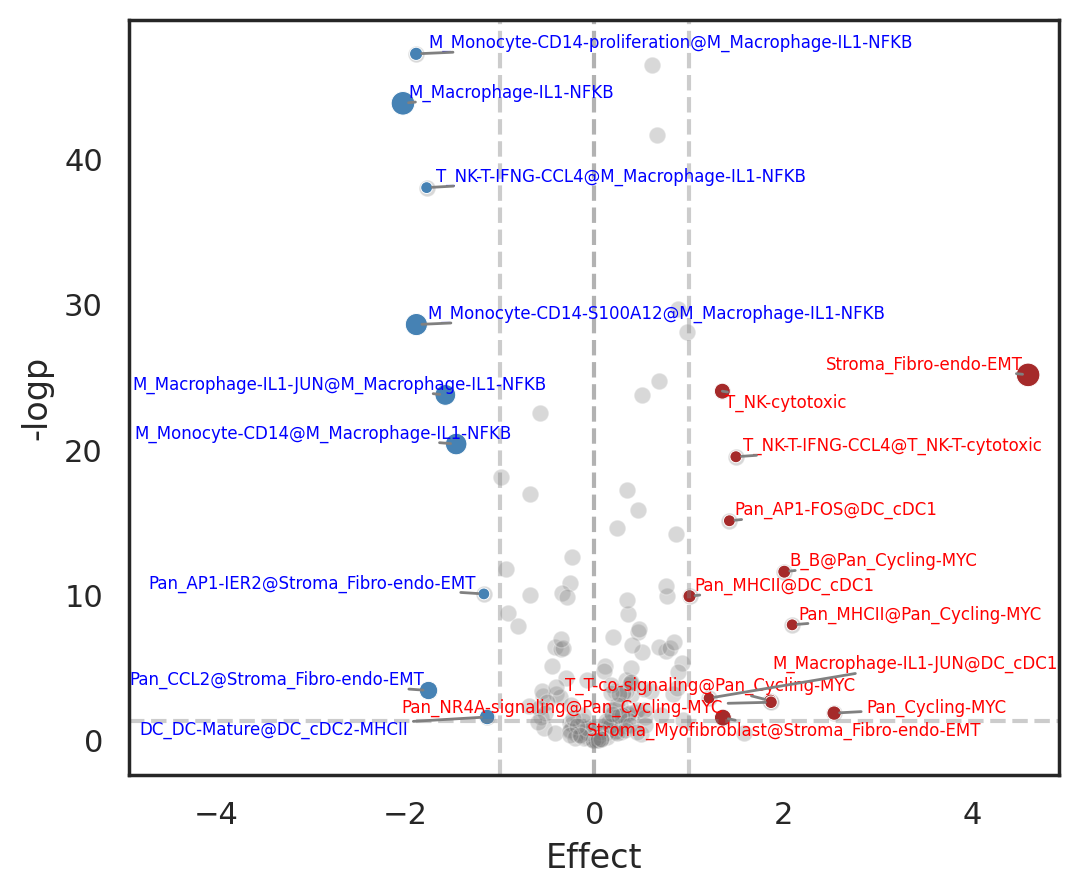

In [30]:
sns.set_theme(style='white')
fig_topdiff = dmec.plot_topdiff(diffmec, fontsize=6)



Save all the significant differential signatures@Cluster

In [32]:

diff, diff_sig = dmec.topdiff_df(diffmec)

In [35]:
diff_sig[:3]

-logp    effect  \
M_Monocyte-CD14-proliferation@M_Macrophage-IL1-...  47.236925 -1.885173   
M_Macrophage-IL1-NFKB                               43.831255 -2.024648   
T_NK-T-IFNG-CCL4@M_Macrophage-IL1-NFKB              38.030503 -1.774028   

                                                     effect1     meanb  \
M_Monocyte-CD14-proliferation@M_Macrophage-IL1-... -1.885173  0.486959   
M_Macrophage-IL1-NFKB                              -2.024648  4.083235   
T_NK-T-IFNG-CCL4@M_Macrophage-IL1-NFKB             -1.774028  0.264443   

                                                       meana scorecol  \
M_Monocyte-CD14-proliferation@M_Macrophage-IL1-...  2.372133   MeC_74   
M_Macrophage-IL1-NFKB                               6.107882   MeC_42   
T_NK-T-IFNG-CCL4@M_Macrophage-IL1-NFKB              2.038471   MeC_34   

                                                                 cluster1  \
M_Monocyte-CD14-proliferation@M_Macrophage-IL1-...  M_Macrophage-IL1-NFKB   
M_Macrophage-IL1-NFKB                               M_Macrophage-IL1-NFKB   
T_NK-T-IFNG-CCL4@M_Macrophage-IL1-NFKB              M_Macrophage-IL1-NFKB   

                                                                              mec  
M_Monocyte-CD14-proliferation@M_Macrophage-IL1-...  M_Monocyte-CD14-proliferation  
M_Macrophage-IL1-NFKB                                       M_Macrophage-IL1-NFKB  
T_NK-T-IFNG-CCL4@M_Macrophage-IL1-NFKB                           T_NK-T-IFNG-CCL4

Saving this table

In [36]:
diff_sig.to_csv('diff_sig_allcluster.txt',sep='\t')